<a href="https://colab.research.google.com/github/yopuedoiralbano/SmartBuildings/blob/main/LPdispatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Requirements.
!pip install pandas seaborn pulp tqdm
# Clear matplotlib cache to ensure Roboto font is available.
!rm -rf ~/.cache/matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 16.5 MB/s eta 0:00:00


In [3]:

import datetime
import io
import logging
import sys
import time
from concurrent.futures import ProcessPoolExecutor
from dataclasses import dataclass
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp
import requests
import seaborn as sns
from tqdm import tqdm

PALETTE = ("#37F8B2", "#00C2FF", "#EB3223", "#A400F1", "#495867", "#FFC15E", "#FFEE82", "#000000", "#808080")


def set_matplotlib_style(seaborn_style: str = "whitegrid", palette=PALETTE):
    """Make some quality of life plotting default tweaks for matplotlib."""
    # First explicitly enable the inline backend (otherwise things get overridden).
    from IPython import get_ipython

    get_ipython().run_line_magic("matplotlib", "inline")

    # Define some rcParams to make plots bigger and not transparent.
    override_rcparams = {
        "figure.dpi": 150,
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "savefig.facecolor": "white",
        "font.family": "sans-serif",
        # "font.sans-serif": ["Roboto"],
    }

    # Tell Seaborn to do its magic.
    sns.set_theme(style=seaborn_style, palette=palette, rc=override_rcparams)


set_matplotlib_style()

In [4]:
# Tesla megapack specs
BATTERY_MW = 100
BATTERY_MWH = 400
BATTERY_ROUND_TRIP_EFFICIENCY = 0.93


# Backcast data

Here we'll pull historical DALMP data, compute a persistence baseline, and compare ARIMA, MSTL, and LSTM models\(time permitting).

Price data is pulled from the CAISO OASIS API.

In [5]:
# Define CAISO OASIS API constants.
_OASIS_BASE_URL = "http://oasis.caiso.com/oasisapi/SingleZip"
_OASIS_TIMESTAMP_FORMAT = "%Y%m%dT%H:%M-0000"

logger = logging.getLogger(__name__)


def _fetch_caiso_data_chunk(queryname, chunk_start, chunk_end, kwargs):
    """Query one chunk of data from the CAISO OASIS `SingleZip` endpoint.

    NOTE: In OASIS, `chunk_start` is inclusive, but `chunk_end` is not.
    """

    # Build query parameters.
    params = {
        "queryname": queryname,
        "startdatetime": chunk_start.strftime(_OASIS_TIMESTAMP_FORMAT),
        "enddatetime": chunk_end.strftime(_OASIS_TIMESTAMP_FORMAT),
        "version": 1,
        "resultformat": 6,  # This flag downloads the results as `.csv` instead of `.xml`.
    }
    params.update(**kwargs)
    logger.info(f"Fetching '{queryname}' for time range: {chunk_start} – {chunk_end} with kwargs: {kwargs}.")
    response = requests.get(_OASIS_BASE_URL, params=params)
    response.raise_for_status()
    logging.info("API call complete, parsing the resulting zipped CSV file")
    with ZipFile(io.BytesIO(response.content)) as zip_file:
        assert len(zip_file.namelist()) == 1
        [filename] = zip_file.namelist()
        if filename.endswith("csv"):
            with zip_file.open(name=filename, mode="r") as f:
                df_chunk = pd.read_csv(f)
        else:
            if filename.endswith("xml"):
                logger.warning(f"Got XML error response:\n{zip_file.read(name=filename)}")
            else:
                logger.warning(f"Encountered file {filename}, skipping")
            df_chunk = pd.DataFrame()
    return df_chunk


def fetch_caiso_data(start_time, end_time, queryname, **kwargs):
    """Fetches data from the CAISO OASIS `SingleZip` API service.

    Args:
        start_time (datetime.datetime): start of time range to fetch data for
        end_time (datetime.datetime): end of time range to fetch data for
        queryname (str): CAISO OASIS `SingleZip` report name
        **kwargs: additional keyword arguments to send in request payload

    Returns:
        data_frame (pd.DataFrame): CAISO data frame
    """
    data_chunks = []
    chunk_start = start_time
    chunk_end = None
    while True:
        # NOTE: OASIS allows max query length of 31 days.
        chunk_end = min(chunk_start + datetime.timedelta(days=28), end_time)

        # Fetch.
        df_chunk = _fetch_caiso_data_chunk(queryname, chunk_start, chunk_end, kwargs)
        data_chunks.append(df_chunk)

        # Check if done.
        if chunk_end == end_time:
            break

        # Advance to next chunk.
        chunk_start = chunk_end
        logging.info("Sleeping 5sec for API timeout")
        time.sleep(5)  # CAISO OASIS throttles when requesting more than once per 5sec.
    return pd.concat(data_chunks)


def _clean_up_index_inplace(df):
    new_index = pd.to_datetime(df.index)
    new_index.name = "INTERVALSTARTTIME"
    new_index = new_index.to_series().dt.tz_convert("America/Los_Angeles")
    df.index = new_index


def fetch_dalmp_data(node, start_time, end_time):
    df = fetch_caiso_data(start_time=start_time, end_time=end_time, queryname="PRC_LMP", node=node, market_run_id="DAM")
    df = df.pivot(index="INTERVALSTARTTIME_GMT", columns="LMP_TYPE", values="MW")
    _clean_up_index_inplace(df)
    return df


def configure_logging(
    level=logging.INFO, log_format="%(asctime)s %(name)s %(processName)s [%(levelname)s]: %(message)s"
):
    """Turn on logging to notebook cell outputs."""
    logger = logging.getLogger()

    # Set the logging level.
    logger.setLevel(level)

    # Ensure there is a single handler with the desired format.
    logger.handlers.clear()
    new_handler = logging.StreamHandler(sys.stdout)
    new_handler.setFormatter(logging.Formatter(log_format))
    logger.addHandler(new_handler)

In [6]:
%%time
SELECTED_PRICE_NODE = "GRIZZLY_7_N101"  # Let's look at the price node near UC Berkeley

TIMEZONE = "US/Pacific"
START_TIME = pd.Timestamp(year=2022, month=1, day=1, tz=TIMEZONE).tz_convert("UTC").to_pydatetime()
END_TIME = pd.Timestamp(year=2024, month=1, day=23, tz=TIMEZONE).tz_convert("UTC").to_pydatetime()
configure_logging(level=logging.INFO)
dalmp_data = fetch_dalmp_data(SELECTED_PRICE_NODE, START_TIME - pd.DateOffset(days=1), END_TIME)
configure_logging(level=logging.ERROR)

2024-01-24 12:17:36,361 __main__ MainProcess [INFO]: Fetching 'PRC_LMP' for time range: 2021-12-31 08:00:00+00:00 – 2022-01-28 08:00:00+00:00 with kwargs: {'node': 'GRIZZLY_7_N101', 'market_run_id': 'DAM'}.
2024-01-24 12:17:39,988 root MainProcess [INFO]: API call complete, parsing the resulting zipped CSV file
2024-01-24 12:17:39,990 __main__ MainProcess [WARNING]: Got XML error response:
b'<?xml version="1.0" encoding="UTF-8"?>\n<m:OASISReport xmlns:m="http://www.caiso.com/soa/OASISReport_v1.xsd">\n<m:MessageHeader>\n\t<m:TimeDate>2024-01-24T12:17:39.956Z</m:TimeDate>\n\t<m:Source>OASIS</m:Source>\n\t<m:Version>v20131201</m:Version>\n</m:MessageHeader>\n<m:MessagePayload>\n<m:RTO>\n<m:name>CAISO</m:name>\n<m:DISCLAIMER_ITEM>\n<m:DISCLAIMER>The contents of these pages are subject to change without notice. Decisions based on information contained within the California ISO\'s web site are the visitor\'s sole responsibility.</m:DISCLAIMER>\n</m:DISCLAIMER_ITEM>\n<m:ERROR>\n<m:ERR_CODE>10

# Forecasting Day-Ahead LMP Prices
ARIMA and MSTL compared to baseline persistence (based off previous 24 hours)


In [54]:
#persistence forecast
dalmp_data.index.name = None
actual_dalmp = dalmp_data["LMP"].rename("actual_dalmp")


persistence_forecast_dalmp = actual_dalmp.shift(24).rename("persistence_forecast_dalmp")
pers_forcomparison = persistence_forecast_dalmp[END_TIME + datetime.timedelta(days=-1) : END_TIME]
# Mock ML forecasts.
# mock_ml_forecast_dalmp = ((9 * persistence_forecast_dalmp + actual_dalmp) / 10).rename("ml_forecast_dalmp")

# df_backcasts = pd.concat([persistence_forecast_dalmp, mock_ml_forecast_dalmp, actual_dalmp], axis=1).dropna()
# df_backcasts

actual_dalmp


2022-01-28 00:00:00-08:00    62.81201
2022-01-28 01:00:00-08:00    45.85120
2022-01-28 02:00:00-08:00    45.70451
2022-01-28 03:00:00-08:00    45.84718
2022-01-28 04:00:00-08:00    47.09298
                               ...   
2024-01-22 19:00:00-08:00    74.20064
2024-01-22 20:00:00-08:00    67.03015
2024-01-22 21:00:00-08:00    65.09679
2024-01-22 22:00:00-08:00    52.55966
2024-01-22 23:00:00-08:00    51.39446
Name: actual_dalmp, Length: 17400, dtype: float64

In [19]:
forecasted_dalmp_data = fetch_dalmp_data(SELECTED_PRICE_NODE, END_TIME, END_TIME + datetime.timedelta(days=1))
forecasted_dalmp_data.index.name = None
actual_dalmp_compare_to_forcast = forecasted_dalmp_data["LMP"].rename("actual_dalmp")

actual_dalmp_compare_to_forcast

2024-01-23 00:00:00-08:00    44.83458
2024-01-23 01:00:00-08:00    44.63920
2024-01-23 02:00:00-08:00    44.12478
2024-01-23 03:00:00-08:00    44.03506
2024-01-23 04:00:00-08:00    44.24414
2024-01-23 05:00:00-08:00    51.45699
2024-01-23 06:00:00-08:00    64.36816
2024-01-23 07:00:00-08:00    65.62131
2024-01-23 08:00:00-08:00    54.41180
2024-01-23 09:00:00-08:00    48.81170
2024-01-23 10:00:00-08:00    48.37757
2024-01-23 11:00:00-08:00    45.09977
2024-01-23 12:00:00-08:00    43.93439
2024-01-23 13:00:00-08:00    42.20765
2024-01-23 14:00:00-08:00    44.82050
2024-01-23 15:00:00-08:00    45.04823
2024-01-23 16:00:00-08:00    65.12343
2024-01-23 17:00:00-08:00    68.64501
2024-01-23 18:00:00-08:00    67.32567
2024-01-23 19:00:00-08:00    65.63189
2024-01-23 20:00:00-08:00    65.07836
2024-01-23 21:00:00-08:00    64.47065
2024-01-23 22:00:00-08:00    56.05689
2024-01-23 23:00:00-08:00    50.83259
Name: actual_dalmp, dtype: float64

In [23]:
%%time
# ARIMA
# DAM model parameters assumed from https://www.osti.gov/servlets/purl/1358239

from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(actual_dalmp, order=(0, 1, 1), seasonal_order=(2, 1, 1, 24))
arima_results = arima_model.fit()

# Forecast the next 24 hours
arima_forecast = arima_results.forecast(steps=24)

arima_forecast



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


CPU times: user 5min 3s, sys: 2min 21s, total: 7min 25s
Wall time: 5min 4s


2024-01-23 00:00:00-08:00    51.064964
2024-01-23 01:00:00-08:00    49.882159
2024-01-23 02:00:00-08:00    49.448138
2024-01-23 03:00:00-08:00    49.333198
2024-01-23 04:00:00-08:00    50.721061
2024-01-23 05:00:00-08:00    54.784936
2024-01-23 06:00:00-08:00    67.218626
2024-01-23 07:00:00-08:00    68.599606
2024-01-23 08:00:00-08:00    67.884427
2024-01-23 09:00:00-08:00    66.334841
2024-01-23 10:00:00-08:00    62.423059
2024-01-23 11:00:00-08:00    59.846029
2024-01-23 12:00:00-08:00    57.786795
2024-01-23 13:00:00-08:00    56.824753
2024-01-23 14:00:00-08:00    57.874961
2024-01-23 15:00:00-08:00    64.846205
2024-01-23 16:00:00-08:00    73.801485
2024-01-23 17:00:00-08:00    78.037631
2024-01-23 18:00:00-08:00    75.170852
2024-01-23 19:00:00-08:00    72.055458
2024-01-23 20:00:00-08:00    66.639892
2024-01-23 21:00:00-08:00    64.473208
2024-01-23 22:00:00-08:00    55.327874
2024-01-23 23:00:00-08:00    52.909547
Freq: H, Name: predicted_mean, dtype: float64

In [27]:
%%time

# MSTL
from statsmodels.tsa.seasonal import MSTL

mstl_model = MSTL(actual_dalmp, periods=(24, 24 * 7, 24*365), stl_kwargs={"seasonal_deg": 0})
res = mstl_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stl/mstl.py:217: UserWarning: A period(s) is larger than half the length of time series. Removing these period(s).
  warnings.warn(


CPU times: user 7.35 s, sys: 17.5 ms, total: 7.37 s
Wall time: 7.43 s


<ipython-input-38-021c3c7b5c83>:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, ax_last)
<ipython-input-38-021c3c7b5c83>:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, ax_last)
<ipython-input-38-021c3c7b5c83>:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, ax_last)
<ipython-input-38-021c3c7b5c83>:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, ax_last)


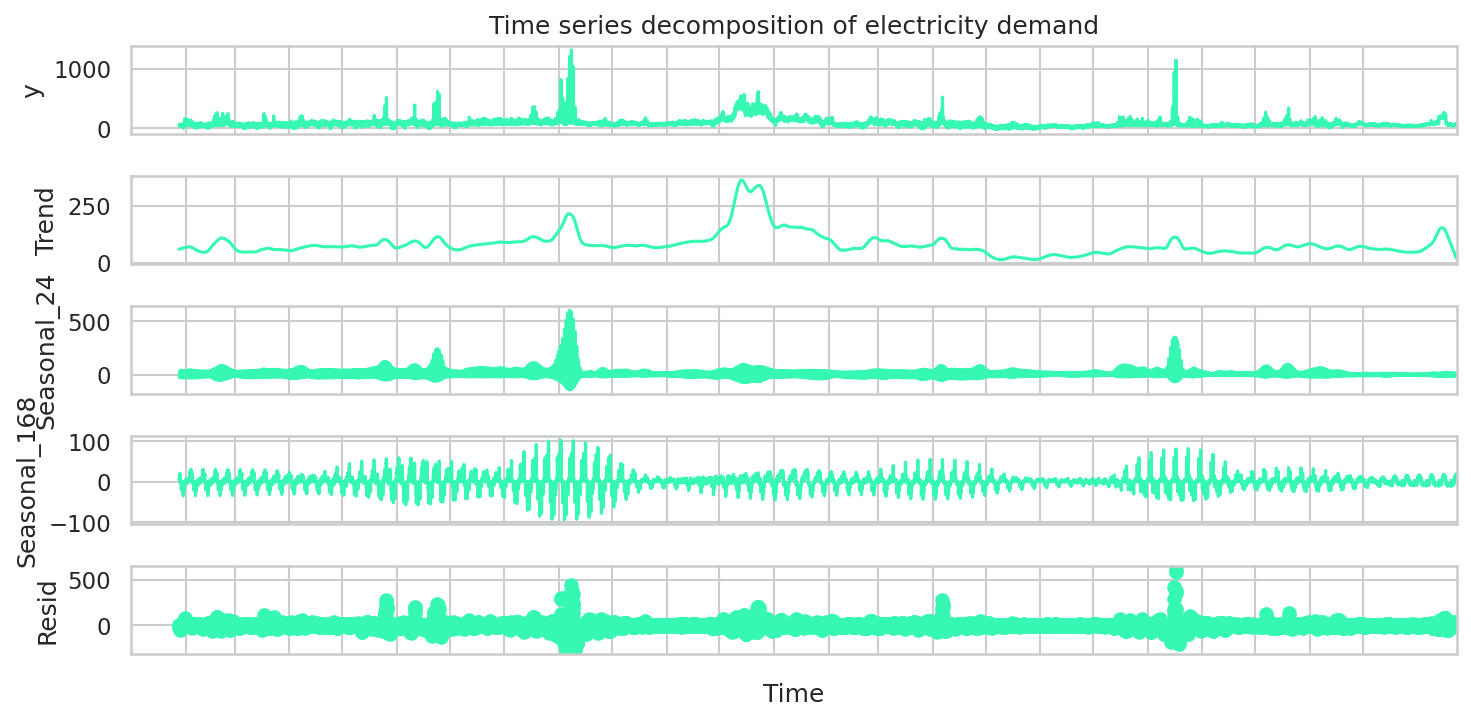

In [38]:
import seaborn as sns
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(10, 5))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2022-01-01", freq="MS", periods=24))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")
for ax in axs[:-1]:
    ax.get_shared_x_axes().join(ax, ax_last)
    ax.xaxis.set_ticks(pd.date_range(start="2022-01-01", freq="MS", periods=24))
    ax.set_xticklabels([])
axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

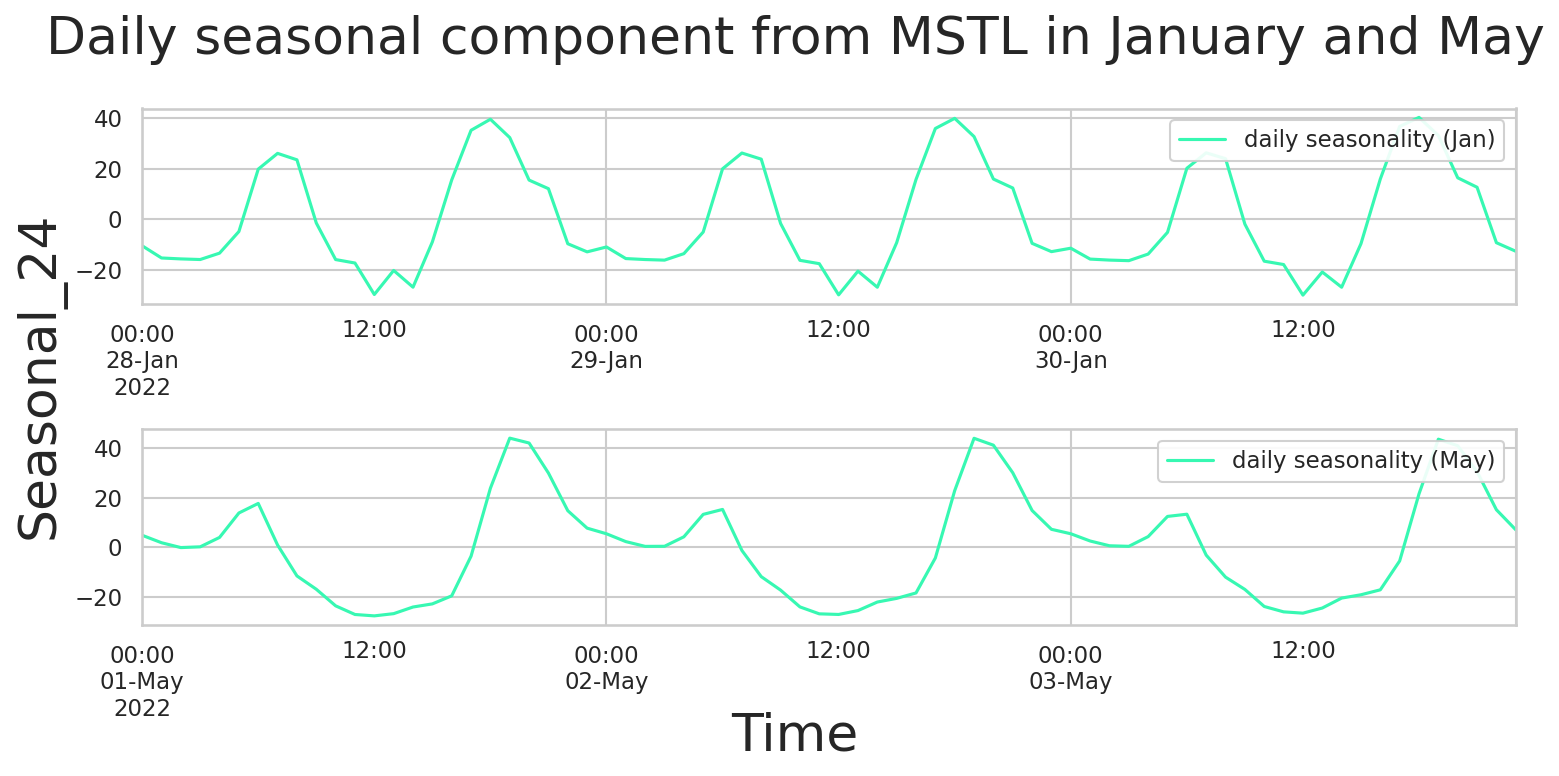

In [37]:
fig, ax = plt.subplots(nrows=2, figsize=[10, 5])
ax = ax.flatten()

# Plot daily seasonality in January
res.seasonal["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[0], label="daily seasonality (Jan)", legend=True
)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].legend(loc="upper right", framealpha=0.9)

# Plot daily seasonality in May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[1], label="daily seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper right", framealpha=0.9)

# Figure labels
fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_24", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

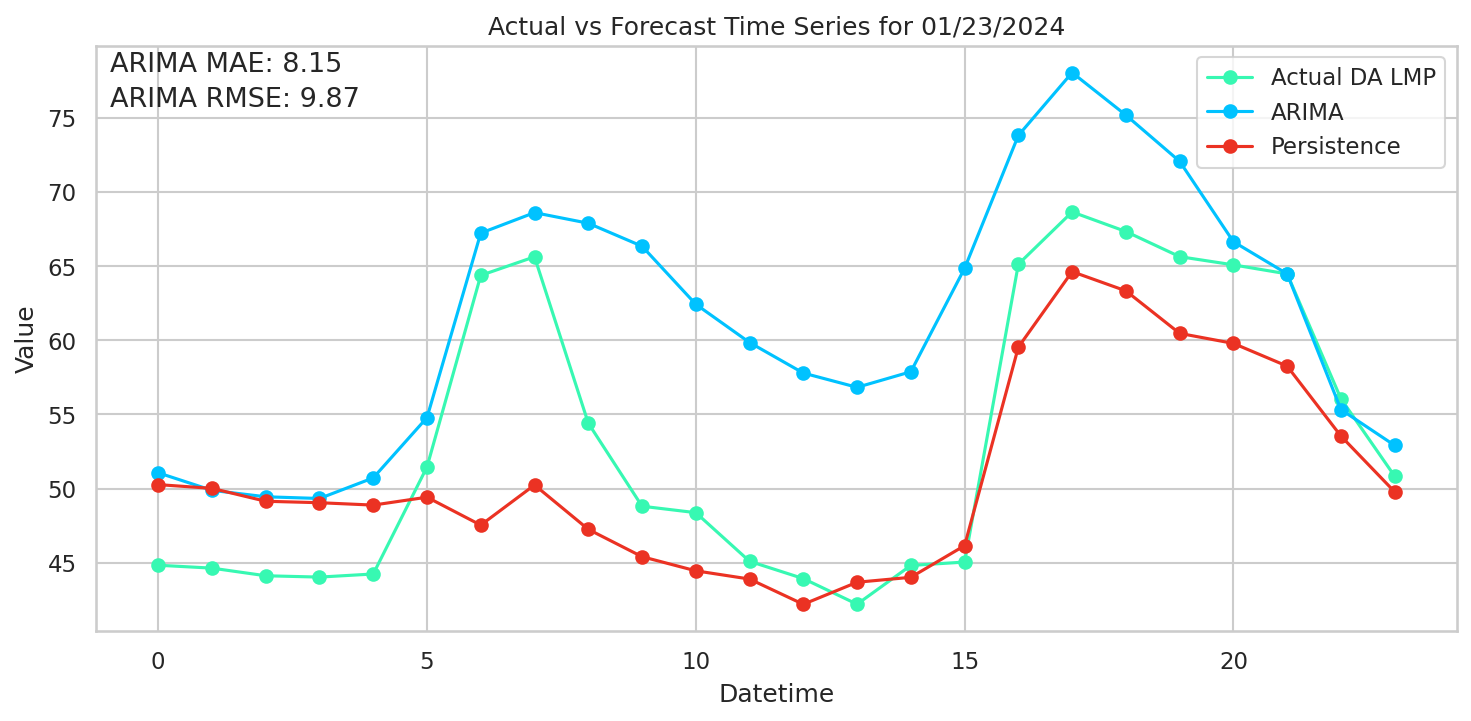

In [56]:
# All Forecasts

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


mae = mean_absolute_error(actual_dalmp_compare_to_forcast, arima_forecast)
rmse = np.sqrt(mean_squared_error(actual_dalmp_compare_to_forcast, arima_forecast))


# Plot the actual vs forecast data
plt.figure(figsize=(10, 5))
plt.plot(actual_dalmp_compare_to_forcast.index.hour, actual_dalmp_compare_to_forcast, 'o-', label='Actual DA LMP')
plt.plot(arima_forecast.index.hour, arima_forecast, 'o-', label='ARIMA')
plt.plot(pers_forcomparison.index.hour, pers_forcomparison, 'o-', label = 'Persistence')

# Add the MAE to the plot
plt.text(0.01, 0.99, f'ARIMA MAE: {mae:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.01, 0.93, f'ARIMA RMSE: {rmse:.2f}', transform=plt.gca().transAxes, verticalalignment='top')


# Add labels, legend, and title
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Actual vs Forecast Time Series for ' + FORECAST_START.strftime("%m/%d/%Y") )
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [25]:


df_backcasts = pd.concat([persistence_forecast_dalmp, mock_ml_forecast_dalmp, actual_dalmp], axis=1).dropna()

# Clip data to whole days only.
hours_of_day = df_backcasts.index.to_series().dt.hour.to_numpy()
first_start_of_day = np.nonzero(hours_of_day == 0)[0][0]
last_end_of_day = np.nonzero(hours_of_day == 23)[0][-1]
selected_slice = slice(first_start_of_day, last_end_of_day + 1)
df_backcasts = df_backcasts.iloc[selected_slice]

,persistence_forecast_dalmp,ml_forecast_dalmp,actual_dalmp
2023-01-01 00:00:00-08:00,113.09076,113.943796,121.62112
2023-01-01 01:00:00-08:00,110.10558,110.686919,115.91897
2023-01-01 02:00:00-08:00,109.77098,110.254204,114.60322
2023-01-01 03:00:00-08:00,107.26382,107.566689,110.29251
2023-01-01 04:00:00-08:00,110.18366,110.071491,109.06197
...,...,...,...
2023-12-31 19:00:00-08:00,47.40230,47.834957,51.72887
2023-12-31 20:00:00-08:00,47.28861,47.726868,51.67119
2023-12-31 21:00:00-08:00,46.88896,47.259698,50.59634
2023-12-31 22:00:00-08:00,46.18980,46.328459,47.57639


In [26]:
# Define function to make names prettier in tables and plots.
def plot_name(name):
    return name.replace("_", " ").capitalize().replace("ml", "ML").replace("Ml", "ML")

# Compute accuracy metrics

In [27]:
df_mae = (
    df_backcasts.drop(columns="actual_dalmp")
    .sub(df_backcasts["actual_dalmp"], axis=0)
    .abs()
    .mean()
    .rename("Average hourly absolute error")
    .to_frame()
    .rename(index={"persistence_forecast_dalmp": "Persistence forecast", "ml_forecast_dalmp": "ML Forecast"})
)
df_mae.style.format("${:.2f}")

,Average hourly absolute error
Persistence forecast,$12.73
ML Forecast,$11.46


(0.0, 14.03390757526541)

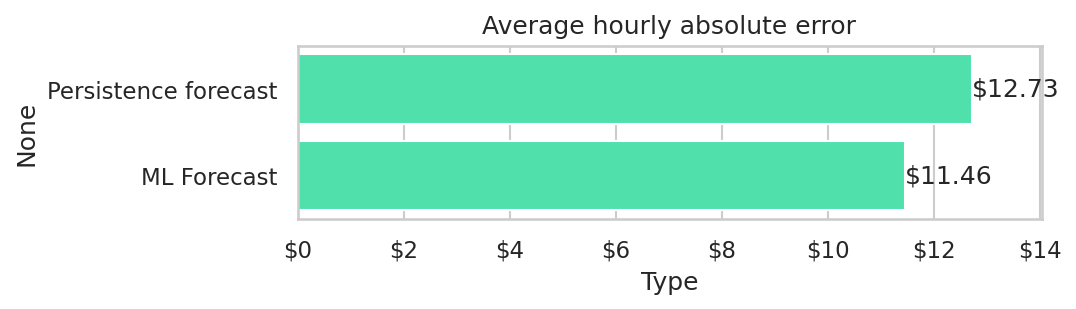

In [74]:
# Plot the above table as a horizontal bar chart.
fig, ax = plt.subplots(figsize=(6.4, 1.5))
ax = sns.barplot(x=df_mae["Average hourly absolute error"], y=df_mae.index, ax=ax)
ax.xaxis.set_major_formatter("${x:.0f}")
ax.set_title("Average hourly absolute error")
ax.set_xlabel(None)
ax.bar_label(ax.containers[0], fmt="$%.2f")
lo, hi = ax.get_xlim()
ax.set_xlim(lo, 1.05 * hi)

In [29]:
df_backcasts

,persistence_forecast_dalmp,ml_forecast_dalmp,actual_dalmp
2023-01-01 00:00:00-08:00,113.09076,113.943796,121.62112
2023-01-01 01:00:00-08:00,110.10558,110.686919,115.91897
2023-01-01 02:00:00-08:00,109.77098,110.254204,114.60322
2023-01-01 03:00:00-08:00,107.26382,107.566689,110.29251
2023-01-01 04:00:00-08:00,110.18366,110.071491,109.06197
...,...,...,...
2023-12-31 19:00:00-08:00,47.40230,47.834957,51.72887
2023-12-31 20:00:00-08:00,47.28861,47.726868,51.67119
2023-12-31 21:00:00-08:00,46.88896,47.259698,50.59634
2023-12-31 22:00:00-08:00,46.18980,46.328459,47.57639


# Hand-chosen scheduling case-study

Before we use linear programming to optimize battery schedules, let's get a sense of the scheduling problem by hand-choosing a schedule or two.

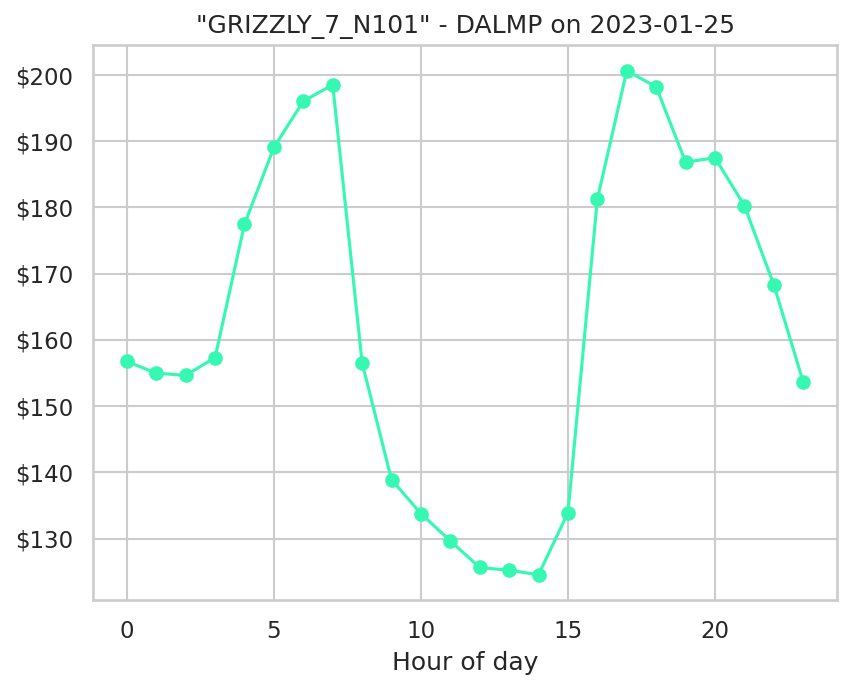

Text(0.5, 0, 'Hour of day')

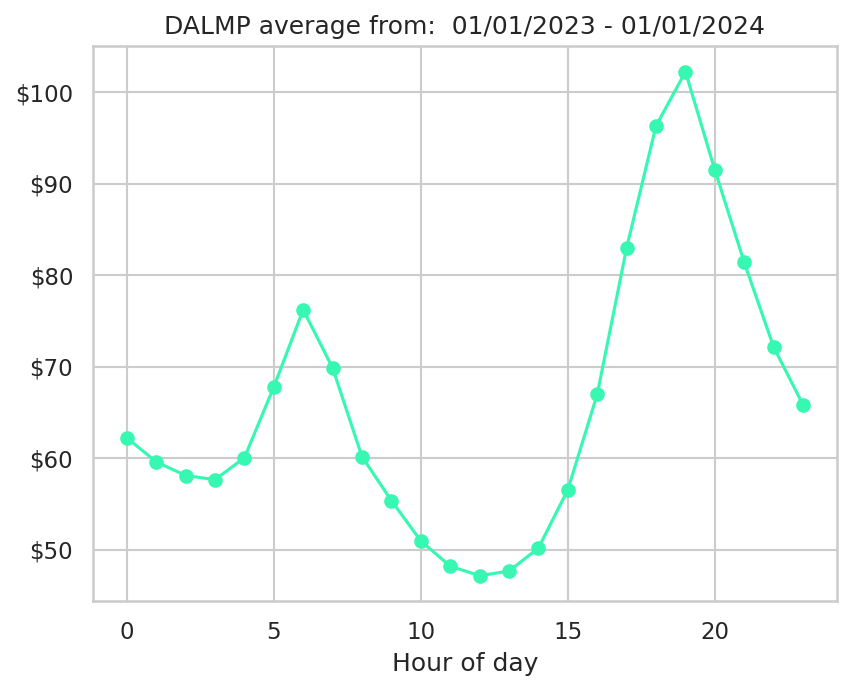

In [70]:
case_study_date = "2023-01-25"
dalmp_case_study = df_backcasts.loc[case_study_date, "actual_dalmp"]
dalmp_case_study.index = dalmp_case_study.index.to_series().dt.hour
dalmp_hourly_average = df_backcasts["actual_dalmp"].groupby(df_backcasts.index.to_series().dt.hour).mean()
ax = dalmp_case_study.plot(marker="o")
ax.yaxis.set_major_formatter("${x:.0f}")
ax.set_title('"'+SELECTED_PRICE_NODE+'"'+ f" - DALMP on {case_study_date}")
ax.set_xlabel("Hour of day")
plt.show()
ax = dalmp_hourly_average.plot(marker="o")
ax.yaxis.set_major_formatter("${x:.0f}")
ax.set_title(f"DALMP average from:  " + START_TIME.strftime("%m/%d/%Y") + " - " + END_TIME.strftime("%m/%d/%Y"))
ax.set_xlabel("Hour of day")

In [32]:
charge_cost = (BATTERY_MW * dalmp_case_study.iloc[7:11]).sum()
discharge_payment = (BATTERY_MW * BATTERY_ROUND_TRIP_EFFICIENCY * dalmp_case_study.iloc[18:22]).sum()
revenue = discharge_payment - charge_cost
print(f"Charge cost: ${charge_cost:,.2f}, discharge payment: ${discharge_payment:,.2f}, revenue: ${revenue:,.2f}")

Charge cost: $62,770.17, discharge payment: $70,011.26, revenue: $7,241.10


In [33]:
# average
charge_cost = (BATTERY_MW * dalmp_hourly_average.iloc[9:13]).sum()
discharge_payment = (BATTERY_MW * BATTERY_ROUND_TRIP_EFFICIENCY * dalmp_hourly_average.iloc[17:21]).sum()
revenue = discharge_payment - charge_cost
n_days = df_backcasts.index.to_series().dt.date.unique().shape[0]
total_revenue_manual = n_days * revenue
print(
    f"Charge cost: ${charge_cost:,.2f}, discharge payment: ${discharge_payment:,.2f}, revenue: ${revenue:,.2f}, total revenue: ${total_revenue_manual:,.0f} over {n_days} days"
)

Charge cost: $20,178.71, discharge payment: $34,703.09, revenue: $14,524.38, total revenue: $5,301,397 over 365 days


# Battery optimization simulation

Here we model the scheduling of a utility-scale battery storage system with a Linear Programming (LP) problem formulation. We restrict ourselves to starting and ending each day with the battery half charged, constrain charging and discharging by the battery's physical limits, and model the battery's round-trip efficiency as the amount of energy charged into from the battery being only 86% of the energy pulled from the grid (or whatever else we have set `BATTERY_ROUND_TRIP_EFFICIENCY` to). The objective function is the maximization of total expected revenue across all charging and discharging over the course of the day.

In [34]:
@dataclass
class BESSParameters:
    """Parameters of a battery energy storage system (BESS) relevant to defining the optimal dispatch problem.

    The battery optimization formulation we study is a simplification of the one presented in this paper: https://www.osti.gov/servlets/purl/1244909, https://www.osti.gov/servlets/purl/1358239

    Default parameters values based on the NREL ATB: https://atb.nrel.gov/electricity/2022/utility-scale_battery_storage

    Attrs:
        power_mw: The max rate that energy that can be charged or discharged, in MW.
        capacity_mwh: The max amount of energy that can be stored in the BESS, in MWH.
        efficiency_fraction: Round-Trip Efficiency -- the fraction of usable energy returned to the grid after charge and discharge.
        initial_state_of_charge_fraction: The fraction of the max storage capacity that is initially available when
            solving the optimal dispatch problem.
    """

    power_mw: float = BATTERY_MW
    capacity_mwh: float = BATTERY_MWH
    efficiency_fraction: float = BATTERY_ROUND_TRIP_EFFICIENCY
    initial_state_of_charge_fraction: float = 0.0


def energy_arbitrage_optimal_dispatch(
    price_series: pd.Series,
    bess_parameters: BESSParameters = BESSParameters(),
) -> pd.DataFrame:
    """Optimize dispatch when participating in a single electricity market (e.g. DA market).

    The decision variables are:
    * Charge & discharge at each time step.

    The objective is to maximize total revenue:
    * Revenue(t) = price(t) * (discharge(t) - charge(t))
    * Total revenue is the sum of revenue(t) for all time periods t

    The objective is subject to the physical constraints of the battery:
    * 0 <= charge(t) <= power_mw
    * 0 <= discharge(t) <= power_mw
    * 0 <= state of charge(t) <= capacity_mwh
    * state_of_charge(0) == state_of_charge(T), where T is the final time step.

    The state of charge changes based on charging, discharging, and the round-trip efficiency.
    * state_of_charge(t + 1) = state_of_charge(t) + (efficiency_fraction * charge(t)) - discharge(t)

    :param price_series: The price of energy, in $/MWH.
    :param bess_parameters:  The parameters and constraints of the BESS.
    :return: DataFrame containing values of the decision variables.
    """
    num_timesteps = len(price_series)

    # Define our variables.
    charge_vars = [pulp.LpVariable(f"charge_{t}", 0, bess_parameters.power_mw) for t in range(num_timesteps)]
    discharge_vars = [pulp.LpVariable(f"discharge_{t}", 0, bess_parameters.power_mw) for t in range(num_timesteps)]
    state_of_charge_vars = [
        pulp.LpVariable(f"state_of_charge_{t}", 0, bess_parameters.capacity_mwh) for t in range(num_timesteps + 1)
    ]

    # Hard-code the initial state of charge.
    state_of_charge_vars[0] = bess_parameters.initial_state_of_charge_fraction * bess_parameters.capacity_mwh

    # Define a maximization problem.
    problem = pulp.LpProblem("energy-arbitrage", pulp.LpMaximize)

    # Define equations for each timestep of charging/discharging.
    for t in range(num_timesteps):
        next_t = t + 1

        # Relate state of charge to charging and discharging.
        current_soc = state_of_charge_vars[t]
        current_charge = charge_vars[t]
        current_discharge = discharge_vars[t]
        state_of_charge_vars[next_t] = (
            current_soc + bess_parameters.efficiency_fraction * current_charge - current_discharge
        )

        # Enforce 0 <= state of charge(t) <= capacity_mwh.
        problem += state_of_charge_vars[next_t] >= 0
        problem += state_of_charge_vars[next_t] <= bess_parameters.capacity_mwh

    # Enforce state_of_charge(0) == state_of_charge(T), where T is the final time step.
    problem += state_of_charge_vars[0] == state_of_charge_vars[-1]

    # Set the objective to maximizing revenue.
    objective = sum([price_series[t] * (discharge_vars[t] - charge_vars[t]) for t in range(num_timesteps)])
    problem += objective

    # Solve the problem.
    solver = pulp.PULP_CBC_CMD(msg=0)
    status = problem.solve(solver=solver)
    status_str = pulp.LpStatus[status]
    if status_str != "Optimal":
        raise RuntimeError(f"Solver returned non-optimal status: {status_str}")

    # Export the results.
    frame = pd.DataFrame(
        {
            "charge": [pulp.value(var) for var in charge_vars],
            "discharge": [pulp.value(var) for var in discharge_vars],
            "ending_state_of_charge": [pulp.value(var) for var in state_of_charge_vars[1:]],
        },
        index=price_series.index,
    )
    return frame


def daily_energy_arbitrage_optimal_dispatch(
    price_series: pd.Series, bess_parameters: BESSParameters = BESSParameters()
):
    """Perform daily energy arbitrage optimal dispatch across a longer price series.

    NOTE: Since PuLP has significant overhead (the actual solver is quite fast), multiprocessing speeds this up.
    """
    daily_indices = price_series.groupby(pd.Grouper(freq="D")).indices.values()
    args = [price_series.iloc[idx] for idx in daily_indices]
    with ProcessPoolExecutor(max_workers=8) as pool:
        res = pool.map(energy_arbitrage_optimal_dispatch, args)
    try:
        return pd.concat(res)
    except:
        return

In [36]:
indices_by_day = df_backcasts.groupby(pd.Grouper(freq="D")).indices
results = {}
for forecast_name, data_name in tqdm(
    [
        ("persistence", "persistence_forecast_dalmp"),
        ("ml_forecast", "ml_forecast_dalmp"),
        ("perfect", "actual_dalmp"),
    ]
):
    forecast = df_backcasts[data_name]
    schedule = daily_energy_arbitrage_optimal_dispatch(forecast)
    # schedule = energy_arbitrage_optimal_dispatch(forecast)
    net_discharge = schedule["discharge"] - schedule["charge"]
    schedule["expected_revenue"] = forecast * net_discharge
    schedule["actual_revenue"] = df_backcasts["actual_dalmp"] * net_discharge
    results[forecast_name] = schedule

100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


In [37]:
df_results = pd.concat(results, axis=1)

# Look at a schedule chosen by optimization

In [38]:
import matplotlib.colors
import colorsys


def to_hsv(c):
    rgb = matplotlib.colors.to_rgb(c)
    hsv = matplotlib.colors.rgb_to_hsv(rgb)
    return hsv


def to_hls(c):
    r, g, b = matplotlib.colors.to_rgb(c)
    hls = colorsys.rgb_to_hls(r, g, b)
    return hls


def change_hsv_value(hex_color, new_v):
    h, s, v = to_hsv(hex_color)
    new_color = matplotlib.colors.hsv_to_rgb(h, s, new_v)
    new_color_hex = matplotlib.colors.rgb2hex(new_color)
    print(f"Changing value of {hex_color} from {v} to {new_v}, i.e. {hex_color} to {new_color_hex}")
    return new_color_hex


def change_lightness(hex_color, new_lightness):
    h, l, s = to_hls(hex_color)
    new_rgb = colorsys.hls_to_rgb(h, new_lightness, s)
    new_color_hex = matplotlib.colors.rgb2hex(new_rgb)
    print(f"Changing lightness of {hex_color} from {l} to {new_lightness}, i.e. {hex_color} to {new_color_hex}")
    return new_color_hex


color1, color2, color3, *_ = PALETTE
color_gray = PALETTE[-1]

dark_color_1 = change_lightness(color1, 0.3)
dark_color_2 = change_lightness(color2, 0.3)
dark_color_3 = change_lightness(color3, 0.3)
dark_gray = change_lightness(color_gray, 0.3)

Changing lightness of #37F8B2 from 0.5941176470588235 to 0.3, i.e. #37F8B2 to #059460
Changing lightness of #00C2FF from 0.5 to 0.3, i.e. #00C2FF to #007499
Changing lightness of #EB3223 from 0.5294117647058824 to 0.3, i.e. #EB3223 to #8c160d
Changing lightness of #808080 from 0.5019607843137255 to 0.3, i.e. #808080 to #4c4c4c


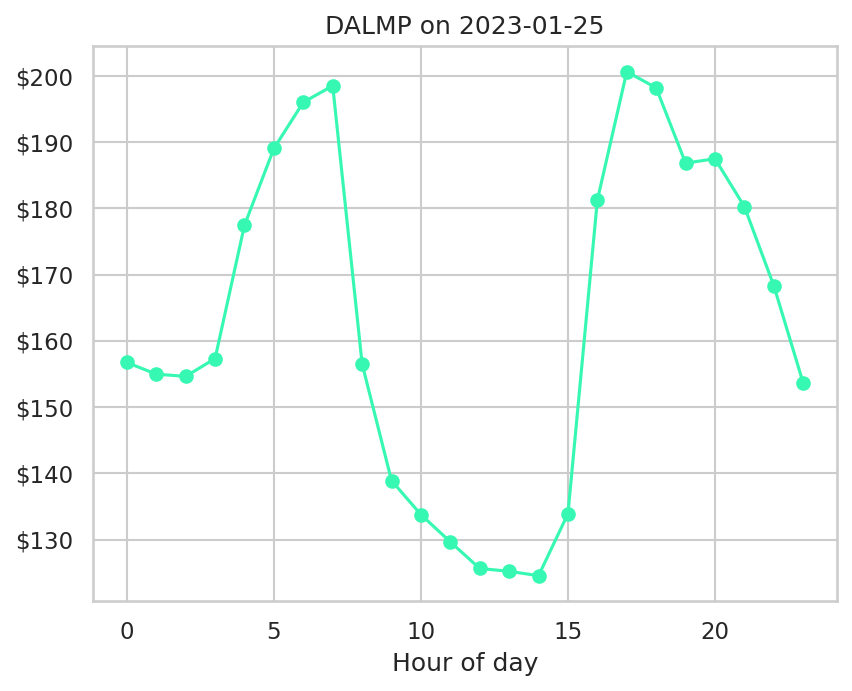

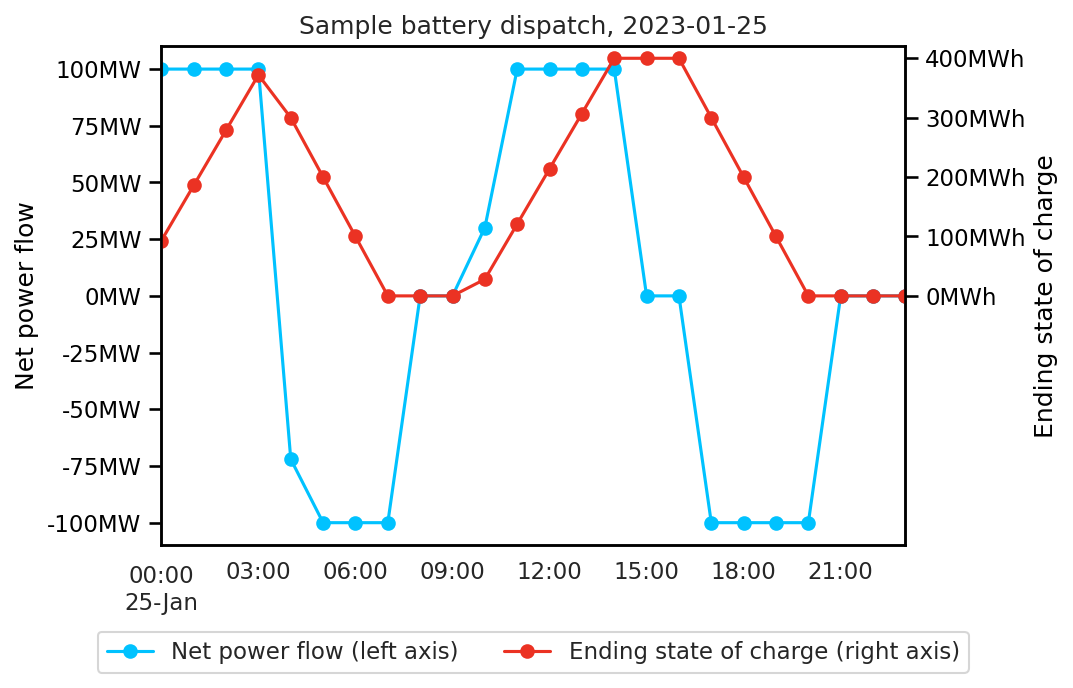

In [48]:
def plot_battery_schedule(
    flow_color,
    soc_color,
    flow_axis_color=None,
    soc_axis_color=None,
    central_axis_color=None,
    align_yaxis_zero=False,
    legend=False,
):
    if flow_axis_color is None:
        flow_axis_color = flow_color
    if soc_axis_color is None:
        soc_axis_color = soc_color
    if central_axis_color is None:
        central_axis_color = "black"
    with sns.axes_style("white"):
        df_net_power_flow = df_results.xs("charge", axis=1, level=1) - df_results.xs("discharge", axis=1, level=1)
        ax1 = df_net_power_flow.loc[case_study_date, "perfect"].plot(marker="o", color=flow_color)
        ax2 = ax1.twinx()

        ax2.spines["left"].set_color(flow_axis_color)
        ax1.tick_params(axis="y", colors=flow_axis_color)
        ax1.yaxis.label.set_color(flow_axis_color)

        ax2.spines["right"].set_color(soc_axis_color)
        ax2.tick_params(axis="y", colors=soc_axis_color)
        ax2.yaxis.label.set_color(soc_axis_color)

        ax2.spines["top"].set_color(central_axis_color)
        ax2.spines["bottom"].set_color(central_axis_color)

        df_results.xs("ending_state_of_charge", axis=1, level=1).loc[case_study_date, "perfect"].plot(
            marker="o", ax=ax2, color=soc_color
        )
        ax1.set_title("Sample battery dispatch, " + case_study_date)
        ax1.set_ylabel("Net power flow")
        ax2.set_ylabel("Ending state of charge")
        ax1.set_xlabel(None)
        ax1.yaxis.set_major_formatter("{x:.0f}MW")
        ax2.yaxis.set_major_formatter("{x:.0f}MWh")

        if align_yaxis_zero:
            lo, hi = ax2.get_ylim()
            ax2.set_ylim(-hi, hi)
            ax2.set_yticks([t for t in ax2.get_yticks() if t >= 0])
            ax2.set_ylim(-hi, hi)

        if legend:
            # Shrink current axis by 20%
            box = ax1.get_position()
            ax1.set_position([box.x0, box.y0 + 0.1 * box.height, box.width, 0.9 * box.height])

            # Put a legend to the right of the current axis
            [h1], [l1] = ax1.get_legend_handles_labels()
            [h2], [l2] = ax2.get_legend_handles_labels()
            ax1.legend(
                [h1, h2],
                ["Net power flow (left axis)", "Ending state of charge (right axis)"],
                loc="upper center",
                ncol=2,
                bbox_to_anchor=(0.5, -0.15),
            )

    return ax1

# case study DALMP
case_study_date = "2023-01-25"
dalmp_case_study = df_backcasts.loc[case_study_date, "actual_dalmp"]
dalmp_case_study.index = dalmp_case_study.index.to_series().dt.hour
dalmp_hourly_average = df_backcasts["actual_dalmp"].groupby(df_backcasts.index.to_series().dt.hour).mean()
ax = dalmp_case_study.plot(marker="o")
ax.yaxis.set_major_formatter("${x:.0f}")
ax.set_title(f"DALMP on {case_study_date}")
ax.set_xlabel("Hour of day")
plt.show()

# # Light
# plot_battery_schedule(color1, color2, central_axis_color=color_gray)
# plt.show()

# Less colorful with legend, aligned
plot_battery_schedule(
    color2, color3, flow_axis_color="black", soc_axis_color="black", align_yaxis_zero=True, legend=True
)
plt.show()

# # Dark
# plot_battery_schedule(dark_color_1, dark_color_3, central_axis_color=dark_gray)
# plt.show()

# # Alternative dark
# alt_dark1, alt_dark2, *_ = sns.color_palette("dark")
# plot_battery_schedule(alt_dark1, alt_dark2)
# plt.show()

# Explore optimization results

In [40]:
total_revenues = df_results.xs("actual_revenue", axis=1, level=1).sum()
total_revenues = pd.concat([pd.Series({"Fixed schedule": total_revenue_manual}), total_revenues])
df_revenue_comparison = pd.DataFrame(
    {
        "Revenue": total_revenues,
        "Percent of perfect": total_revenues / total_revenues.loc["perfect"],
        "Improvement over persistence": total_revenues / total_revenues["persistence"] - 1,
        "Improvement over fixed schedule": total_revenues / total_revenue_manual - 1,
    }
).rename(index=plot_name)
df_revenue_comparison.index.name = "Forecast type"
df_revenue_comparison.style.format(
    {
        "Revenue": "${:,.0f}",
        "Percent of perfect": "{:.1%}",
        "Improvement over persistence": "{:.1%}",
        "Improvement over fixed schedule": "{:.1%}",
    }
)

,Revenue,Percent of perfect,Improvement over persistence,Improvement over fixed schedule
Forecast type,,,,
Fixed schedule,"$5,301,397",63.7%,-28.9%,0.0%
Persistence,"$7,457,260",89.5%,0.0%,40.7%
ML forecast,"$7,668,699",92.1%,2.8%,44.7%
Perfect,"$8,327,933",100.0%,11.7%,57.1%


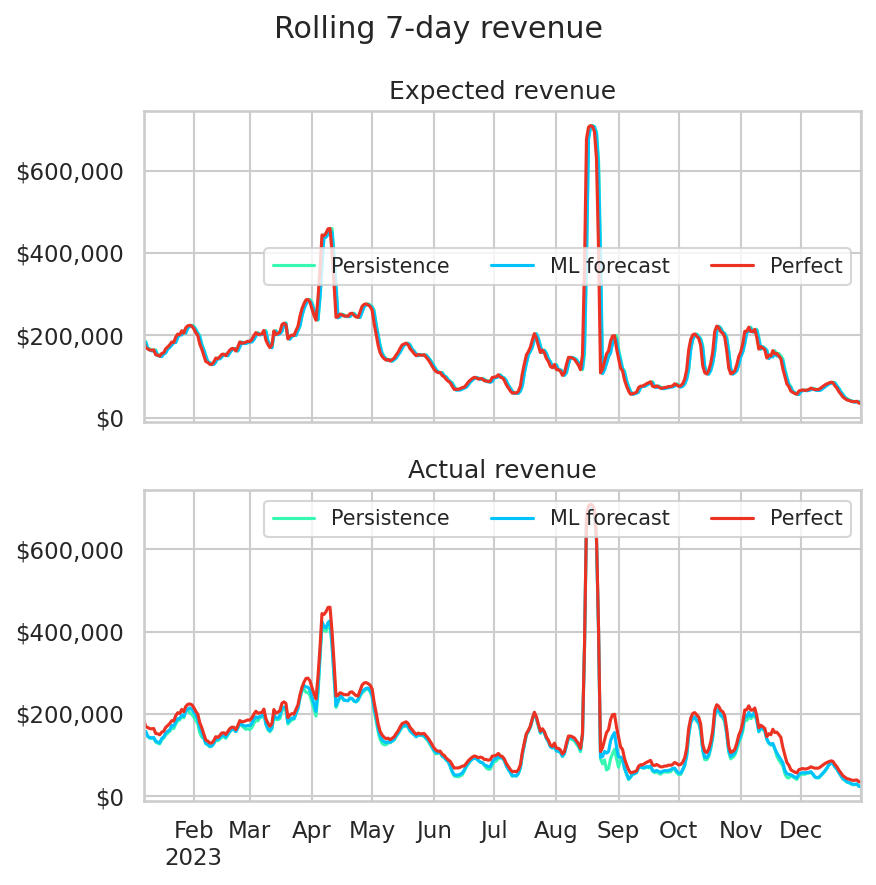

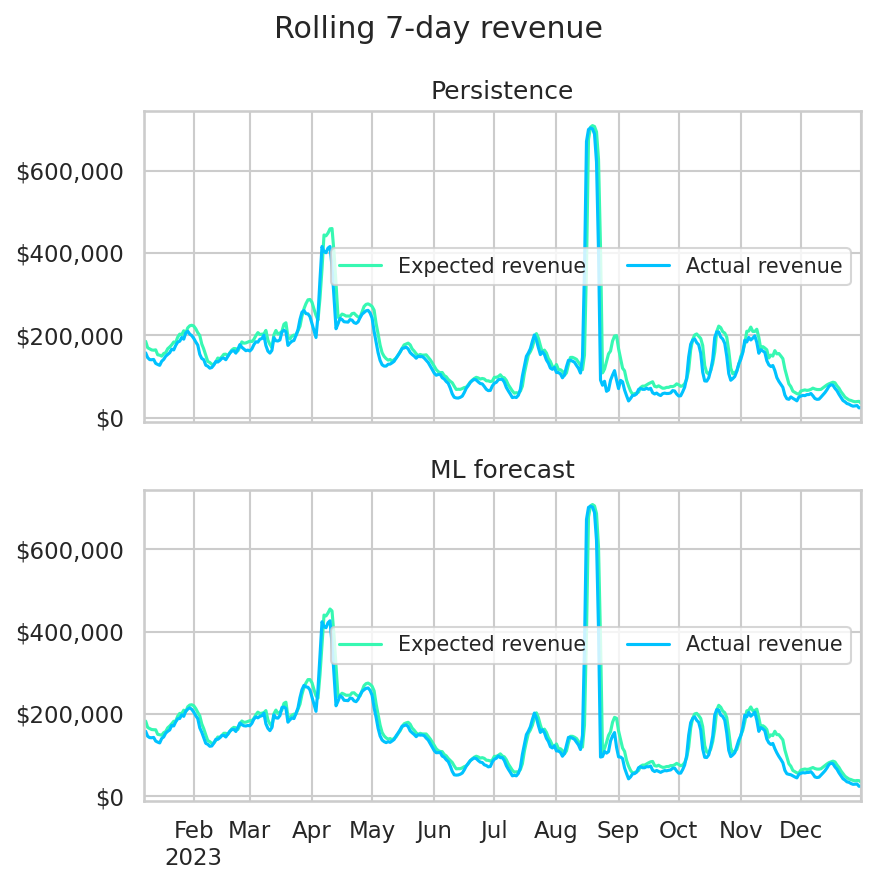

In [41]:
def even_ylim_inplace(axes):
    ylim = (min(ax.get_ylim()[0] for ax in axes), max(ax.get_ylim()[1] for ax in axes))
    for ax in axes:
        ax.set_ylim(ylim)


df_rolling_average_revenue = (
    df_results.loc[:, (slice(None), ["expected_revenue", "actual_revenue"])]
    .groupby(pd.Grouper(freq="d"))
    .sum()
    .rolling("7d", min_periods=7)
    .sum()
).dropna()
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
for ax, level in zip(axes, df_rolling_average_revenue.columns.get_level_values(1).unique()):
    sub_df = df_rolling_average_revenue.xs(level, axis=1, level=1)
    sub_df = sub_df.rename(columns=plot_name)
    sub_df.plot(ax=ax)
    ax.legend(ncol=3, fontsize="small")
    ax.yaxis.set_major_formatter("${x:,.0f}")
    ax.set_xlabel(None)
    ax.set_title(plot_name(level))

even_ylim_inplace(axes)

fig.suptitle("Rolling 7-day revenue")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
for ax, level in zip(axes, ["persistence", "ml_forecast"]):
    sub_df = df_rolling_average_revenue.xs(level, axis=1, level=0)
    sub_df = sub_df.rename(columns=plot_name)
    sub_df.plot(ax=ax)
    ax.legend(ncol=3, fontsize="small")
    ax.yaxis.set_major_formatter("${x:,.0f}")
    ax.set_xlabel(None)
    ax.set_title(plot_name(level))
even_ylim_inplace(axes)

fig.suptitle("Rolling 7-day revenue")
fig.tight_layout()
plt.show()

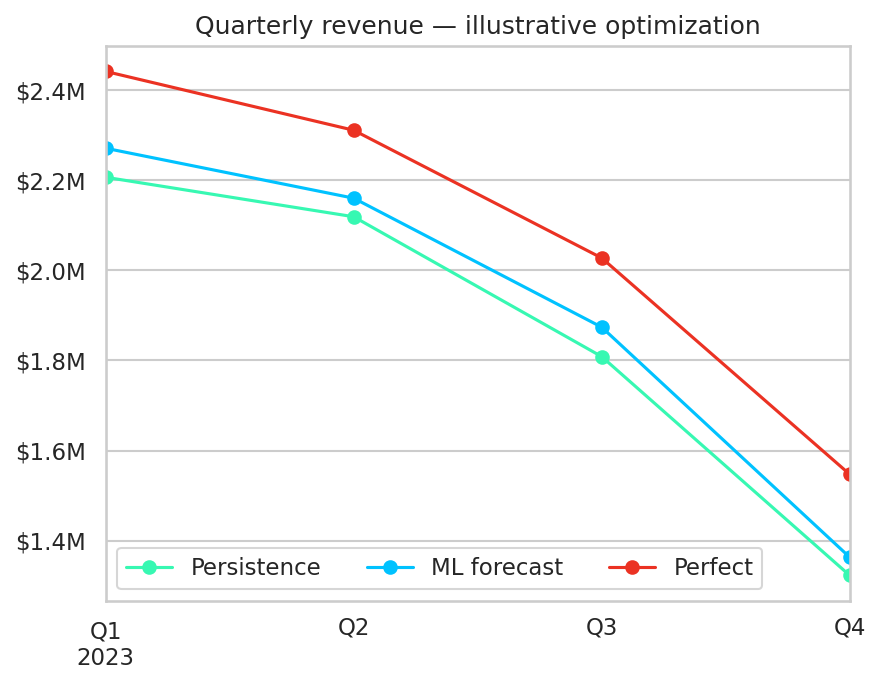

In [42]:
df_quarterly_revenue = df_results.xs("actual_revenue", axis=1, level=1).groupby(pd.Grouper(freq="Q")).sum().div(1e6)
ax = df_quarterly_revenue.rename(columns=plot_name).plot(marker="o")
ax.yaxis.set_major_formatter("${x:,.1f}M")
ax.set_xlabel(None)
ax.set_title("Quarterly revenue — illustrative optimization")
ax.legend(ncol=3)

Text(0.5, 0, '')

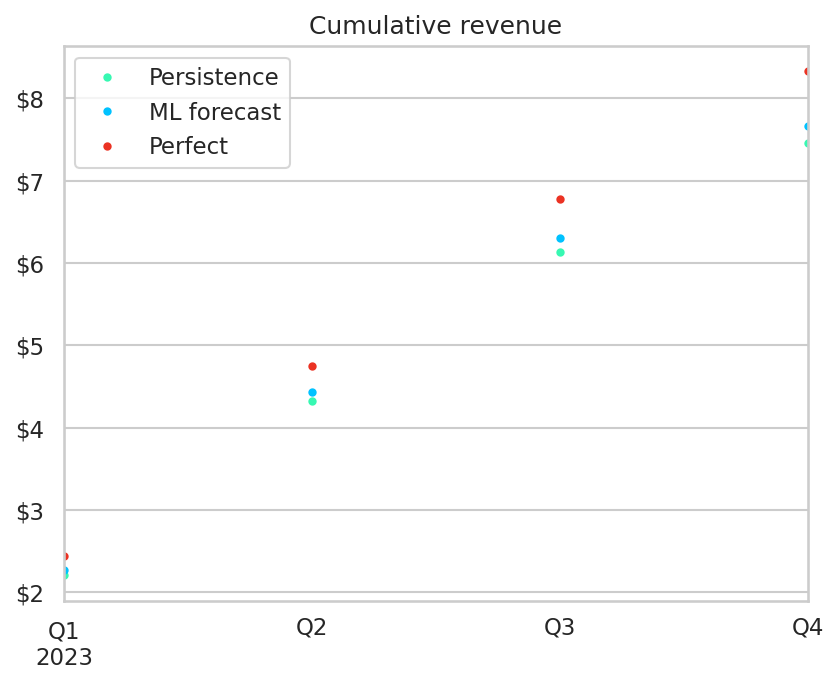

In [43]:
ax = df_quarterly_revenue.cumsum().rename(columns=plot_name).plot(ls="", marker="o", ms=3)
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title("Cumulative revenue")
ax.set_xlabel(None)

In [ ]:
total_revenue = df_results.xs("actual_revenue", axis=1, level=1).sum()
(total_revenue / total_revenue["persistence"] - 1).rename("Revenue lift over persistence").to_frame().rename(
    index=plot_name
).style.format("{:.2%}")

,Revenue lift over persistence
Persistence,0.00%
ML forecast,0.46%
Perfect,2.86%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


Text(0.5, 1.0, 'Quarterly marginal revenue increase over persistence')

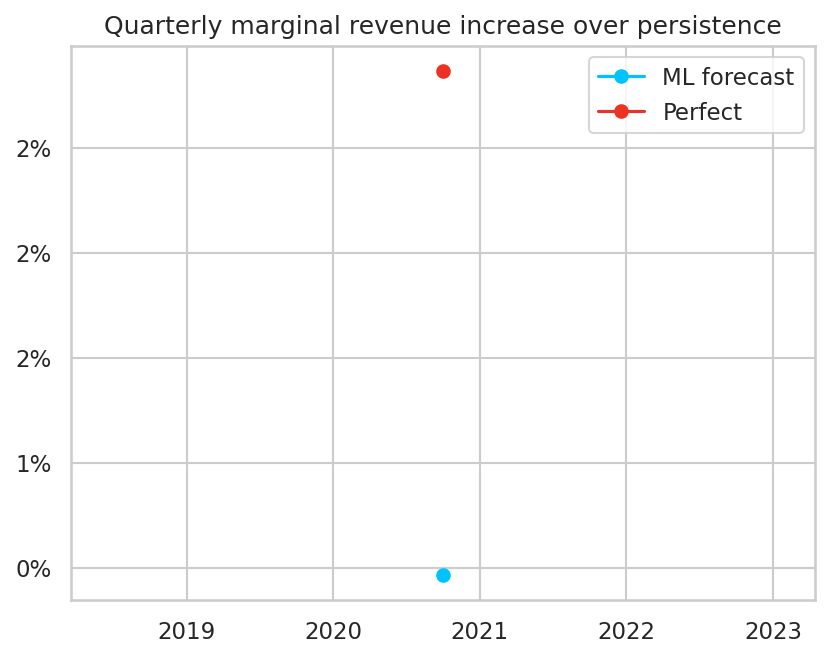

In [ ]:
df_marginal = (
    df_quarterly_revenue.drop(columns="persistence")
    .sub(df_quarterly_revenue["persistence"], axis=0)
    .div(df_quarterly_revenue["persistence"], axis=0)
).rename(columns=plot_name)
ax = df_marginal.plot(marker="o", color=PALETTE[1:])
ax.yaxis.set_major_formatter("{x:,.0%}")
ax.set_xlabel(None)
ax.set_title("Quarterly marginal revenue increase over persistence")

Text(0.5, 1.0, 'Cumulative marginal revenue increase over persistence')

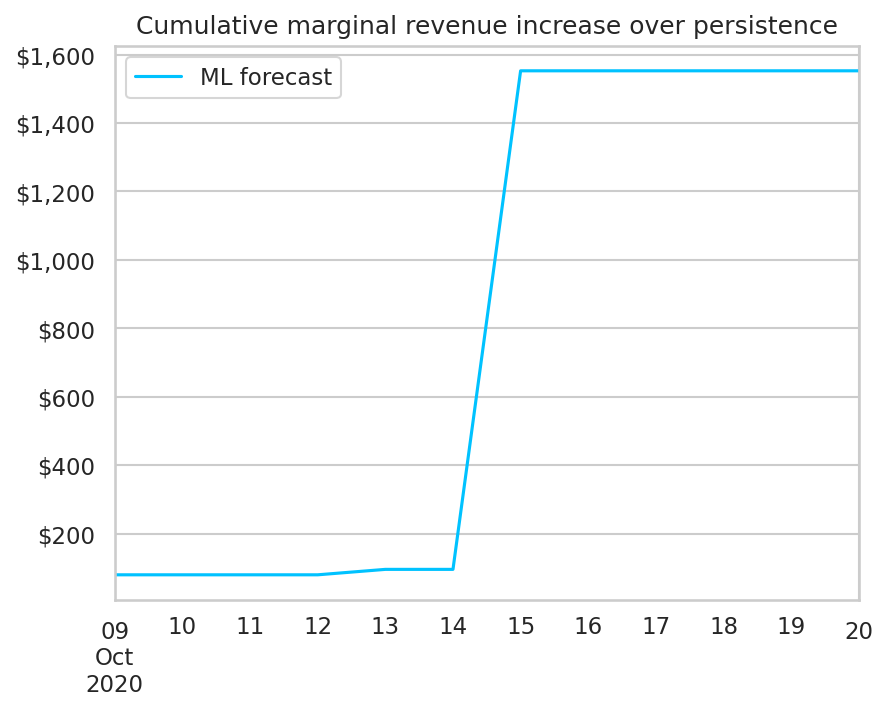

In [ ]:
df_daily_revenue = df_results.xs("actual_revenue", axis=1, level=1).groupby(pd.Grouper(freq="d")).sum()
df_marginal_revenue = df_daily_revenue[["ml_forecast"]].sub(df_daily_revenue["persistence"], axis=0)
ax = df_marginal_revenue.cumsum().rename(columns=plot_name).plot(color=PALETTE[1:])
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_xlabel(None)
ax.set_title("Cumulative marginal revenue increase over persistence")